In [126]:
using MLDataPattern
using Plots; pyplot()
using ProgressMeter
using JLD
using DrakeVisualizer, GeometryTypes, CoordinateTransformations
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

true

In [127]:
import Nets
reload("Nets")

In [267]:
include("../../pympc.jl")
colmat = PyMPC.colmat

Test Summary:    | Pass  Total
test sensitivity |  267    267


colmat (generic function with 1 method)

In [340]:
sys = PyMPC.Models.Pendulum(PyMPC.Models.PendulumParams{Float64}(t_s=0.2, u_min=[-2]))

PyMPC.Models.Pendulum{Float64}(PyObject <pympc.dynamical_systems.DTPWASystem object at 0x12f977210>, PyMPC.Models.PendulumParams{Float64}
  m: Float64 1.0
  l: Float64 1.0
  g: Float64 9.81
  t_s: Float64 0.2
  bin_angle: Float64 1.5707963267948966
  x_min: Array{Float64}((2,)) [-6.28319, -31.4159]
  x_max: Array{Float64}((2,)) [6.28319, 31.4159]
  u_min: Array{Float64}((1,)) [-2.0]
  u_max: Array{Float64}((1,)) [2.0]
, PyCall.PyObject[PyObject <pympc.geometry.Polytope instance at 0x10bd497e8>, PyObject <pympc.geometry.Polytope instance at 0x10bd49ef0>, PyObject <pympc.geometry.Polytope instance at 0x10bd49d40>, PyObject <pympc.geometry.Polytope instance at 0x129ca7bd8>, PyObject <pympc.geometry.Polytope instance at 0x129ca75a8>, PyObject <pympc.geometry.Polytope instance at 0x129ca7ab8>, PyObject <pympc.geometry.Polytope instance at 0x134dc7fc8>, PyObject <pympc.geometry.Polytope instance at 0x1341a8cf8>, PyObject <pympc.geometry.Polytope instance at 0x129ca7cb0>], PyCall.PyObject[PyO

In [332]:
vis = Visualizer()[:pendulum]
setgeometry!(vis, sys)
settransform!(vis, sys, [0, 0])

Set{Array{Symbol,1}}()

In [333]:
# x0 = [π - π/3, 0.0]
# xs = PyMPC.Models.simulate(sys, x0, x -> [0.0], N_sim=30);
# PyMPC.Models.playback(vis, sys, xs);

In [334]:
controller = PyMPC.Models.controller(sys; N=20)

PyObject <pympc.control.MPCHybridController instance at 0x135104518>

In [335]:
x0 = [π - 0.1, 0.0]
result = controller[:feedforward](colmat(x0))

(Any[[3.0], [2.48411], [-2.63227], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-3.0], [-2.72048], [-1.89272], [-1.44258], [-1.1139], [-0.861617]], Any[[3.04159; 0.0], [3.04159; 0.7962], [3.20083; 1.48922], [3.49868; 0.846541], [3.66799; -0.454059], [3.57717; -2.08684], [3.15981; -3.54145], [2.45151; -4.17718], [1.61608; -3.42325], [0.931428; -2.06125]  …  [0.379327; -0.280625], [0.323202; -0.136385], [0.295925; -0.102262], [0.275473; -0.121656], [0.251142; -0.181178], [0.214906; -0.232534], [0.168399; -0.189432], [0.130513; -0.147548], [0.101003; -0.114262], [0.0781506; -0.0884176]], 1439.126762835405, (6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4))

In [336]:
PyMPC.Models.playback(vis, sys, vec.(result[2]));

In [337]:
# x0 = [π - 0.1, 0.0]
# xs = PyMPC.Models.simulate(sys, x0, controller, N_sim=50);

# PyMPC.Models.playback(vis, sys, xs);

In [341]:
# num_samples = 100
# data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

# @showprogress for i in 1:num_samples
#     while true
#         x0 = PyMPC.Models.generate_x0(sys)
#         u, J, x_traj = PyMPC.run_mpc(controller, x0)
#         if !isnan(u[1])
#             PyMPC.Models.playback(vis, sys, vec.(x_traj))
#             push!(data, (x0, hcat(u, J[1:length(u), :])))
#             for x in x_traj
#                 u, J, _ = PyMPC.run_mpc(controller, vec(x))
#                 if !isnan(u[1])
#                     push!(data, (vec(x), hcat(u, J[1:length(u), :])))
#                 end
#             end
#             break
#         end
#     end
# end

# save("pendulum_100_traj.jld", "data", data)

Progress: 100%|█████████████████████████████████████████| Time: 1:54:18


In [342]:
data = load("pendulum_100_traj.jld")["data"]
train_data, test_data = splitobs(shuffleobs(data), 0.5)

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

AffineMap([0.333333], [0.0])

In [353]:
widths = [2, 16, 16, 16, 1]

function sensitive_loss(λ)
    q = fill(λ, widths[1])
    q[1] = 1.0 - λ
    (params, x, y) -> sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params)), x) .- y))
end

sensitive_loss (generic function with 1 method)

In [354]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 200;

mean((xy->begin  # In[401], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 5.799079533434244


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

mean((xy->begin  # In[401], line 16:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.9920657780309247


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45



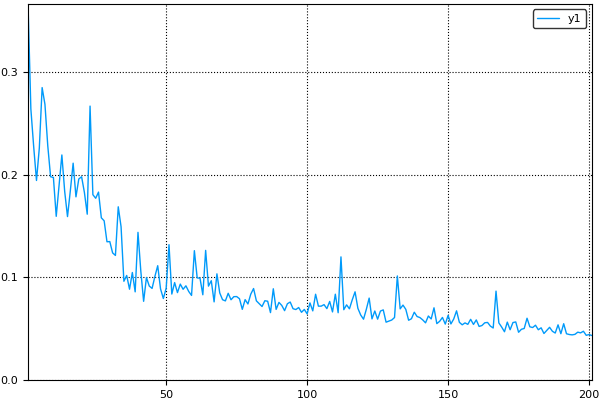

In [401]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), x_to_u, v_to_y)

train_loss = sensitive_loss(0.5)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
#     train_loss = sensitive_loss(0.1)
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=10))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))

In [402]:
netcontroller = x -> clamp.(net(x), sys.params.u_min, sys.params.u_max)

(::#87) (generic function with 1 method)

In [411]:
sim_sys = sys = PyMPC.Models.Pendulum(PyMPC.Models.PendulumParams{Float64}(t_s=0.1, bin_angle=π/8, u_min=[-2]));

PyMPC.Models.Pendulum{Float64}(PyObject <pympc.dynamical_systems.DTPWASystem object at 0x13517bc50>, PyMPC.Models.PendulumParams{Float64}
  m: Float64 1.0
  l: Float64 1.0
  g: Float64 9.81
  t_s: Float64 0.1
  bin_angle: Float64 0.39269908169872414
  x_min: Array{Float64}((2,)) [-6.28319, -31.4159]
  x_max: Array{Float64}((2,)) [6.28319, 31.4159]
  u_min: Array{Float64}((1,)) [-2.0]
  u_max: Array{Float64}((1,)) [2.0]
, PyCall.PyObject[PyObject <pympc.geometry.Polytope instance at 0x135608638>, PyObject <pympc.geometry.Polytope instance at 0x1355cf9e0>, PyObject <pympc.geometry.Polytope instance at 0x135608f38>, PyObject <pympc.geometry.Polytope instance at 0x1355d3dd0>, PyObject <pympc.geometry.Polytope instance at 0x1355d37e8>, PyObject <pympc.geometry.Polytope instance at 0x1355d3830>, PyObject <pympc.geometry.Polytope instance at 0x1355dfe60>, PyObject <pympc.geometry.Polytope instance at 0x1355dfbd8>, PyObject <pympc.geometry.Polytope instance at 0x1355df830>, PyObject <pympc.geo

In [412]:
x0 = PyMPC.Models.generate_x0(sys)
for i in 1:100
    x0 = PyMPC.Models.generate_x0(sys)
    if !any(isnan, controller[:feedback](colmat(x0)))
        break
    end
end
@show x0

x0 = [-3.04691, 1.38462]


2-element Array{Float64,1}:
 -3.04691
  1.38462

In [414]:
xs = PyMPC.Models.simulate(sim_sys, x0, netcontroller; N_sim=200)
PyMPC.Models.playback(vis, sys, xs)

In [409]:
xs = PyMPC.Models.simulate(sim_sys, xs[end], netcontroller; N_sim=100)
PyMPC.Models.playback(vis, sys, xs)